There was a task for one of my Deep Learning courses (implementing this modules) and I want to use it to compare hand-written neural network with the one made on PyTorch.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class Module(object):
    def __init__ (self):
        self.output = None
        self.gradInput = None
        self.training = True
    
    def forward(self, input):
        return self.updateOutput(input)

    def backward(self,input, gradOutput):
        self.updateGradInput(input, gradOutput)
        self.accGradParameters(input, gradOutput)
        return self.gradInput    

    def updateOutput(self, input):
        pass

    def updateGradInput(self, input, gradOutput):
        pass   
    
    def accGradParameters(self, input, gradOutput):
        pass
    
    def zeroGradParameters(self): 
        pass
        
    def getParameters(self):
        return []
        
    def getGradParameters(self):
        return []
    
    def train(self):
        self.training = True
    
    def evaluate(self):
        self.training = False
    
    def __repr__(self):
        return "Module"

In [3]:
class Sequential(Module):
    def __init__ (self):
        super(Sequential, self).__init__()
        self.modules = []
   
    def add(self, module):
        self.modules.append(module)

    def updateOutput(self, input):
        self.output = input
        for mod in self.modules:
            self.output = mod.forward(self.output)
        return self.output

    def backward(self, input, gradOutput):
        self.gradInput = gradOutput
        L = len(self.modules)
        for i in range(L - 1):
            self.gradInput = self.modules[L - i - 1].backward(self.modules[L - i - 2].output, self.gradInput)
        self.gradInput = self.modules[0].backward(input, self.gradInput)
        return self.gradInput
      

    def zeroGradParameters(self): 
        for module in self.modules:
            module.zeroGradParameters()
    
    def getParameters(self):
        return [x.getParameters() for x in self.modules]
    
    def getGradParameters(self):
        return [x.getGradParameters() for x in self.modules]
    
    def __repr__(self):
        string = "".join([str(x) + '\n' for x in self.modules])
        return string
    
    def __getitem__(self,x):
        return self.modules.__getitem__(x)
    
    def train(self):
        self.training = True
        for module in self.modules:
            module.train()
    
    def evaluate(self):
        self.training = False
        for module in self.modules:
            module.evaluate()

In [4]:
class Linear(Module):
    def __init__(self, n_in, n_out):
        super(Linear, self).__init__()
        stdv = 1./np.sqrt(n_in)
        self.W = np.random.uniform(-stdv, stdv, size = (n_out, n_in))
        self.b = np.random.uniform(-stdv, stdv, size = n_out)
        self.gradW = np.zeros_like(self.W)
        self.gradb = np.zeros_like(self.b)
        
    def updateOutput(self, input):
        self.output = np.add(np.dot(input, self.W.T), self.b)
        return self.output
    
    def updateGradInput(self, input, gradOutput):
        self.gradInput = np.dot(gradOutput, self.W)
        return self.gradInput
    
    def accGradParameters(self, input, gradOutput):
        self.gradW = np.dot(gradOutput.T, input)
        self.gradb = gradOutput.sum(axis=0)
        pass
    
    def zeroGradParameters(self):
        self.gradW.fill(0)
        self.gradb.fill(0)
        
    def getParameters(self):
        return [self.W, self.b]
    
    def getGradParameters(self):
        return [self.gradW, self.gradb]
    
    def __repr__(self):
        s = self.W.shape
        q = 'Linear %d -> %d' %(s[1],s[0])
        return q

In [5]:
class SoftMax(Module):
    def __init__(self):
         super(SoftMax, self).__init__()
    
    def updateOutput(self, input):
        self.output = np.subtract(input, input.max(axis=1, keepdims=True))
        self.output = np.divide(np.exp(self.output), np.sum(np.exp(self.output), axis=1, keepdims=True))
        return self.output
    
    def updateGradInput(self, input, gradOutput):
        out_matr = self.output * gradOutput
        self.gradInput = out_matr - self.output * np.sum(out_matr, axis=1, keepdims = True)
        return self.gradInput
    
    def __repr__(self):
        return "SoftMax"

In [6]:
class LogSoftMax(Module):
    def __init__(self):
         super(LogSoftMax, self).__init__()
    
    def updateOutput(self, input):
        self.output = np.subtract(input, input.max(axis=1, keepdims=True))
        self.output = np.subtract(self.output, np.log(np.sum(np.exp(self.output), axis=1, keepdims=True)))
        return self.output
    
    def updateGradInput(self, input, gradOutput):
        self.gradInput = np.zeros((input.shape[0], input.shape[1]))
        for i in range(input.shape[0]):
            self.gradInput[i] = np.dot(gradOutput[i], np.eye(input.shape[1]) - np.exp(self.output)[i])
        return self.gradInput
    
    def __repr__(self):
        return "LogSoftMax"

In [7]:
class BatchNormalization(Module):
    EPS = 1e-3
    def __init__(self, alpha = 0.):
        super(BatchNormalization, self).__init__()
        self.alpha = alpha
        self.moving_mean = None 
        self.moving_variance = None
        
    def updateOutput(self, input):
        if self.training == True:
            if self.moving_mean is None:
                self.moving_mean = np.mean(input, axis=0)
            else:
                self.moving_mean = self.moving_mean * self.alpha + np.mean(input, axis=0)  * (1 - self.alpha) 
            if self.moving_variance is None:
                self.moving_variance = np.var(input, axis=0)
            else:
                self.moving_variance = self.moving_variance * self.alpha + np.var(input, axis=0) * (1 - self.alpha)
            self.output = np.divide(input - np.mean(input, axis=0), np.sqrt(np.var(input, axis=0) + self.EPS))
        else:
            self.output = np.divide(input - self.moving_mean, np.sqrt(self.moving_variance + self.EPS))
        return self.output
    
    def updateGradInput(self, input, gradOutput):
        div_matr = gradOutput / (np.sqrt(np.var(input, axis=0) + self.EPS))
        self.gradInput = (np.mean(input, axis=0) - input) / input.shape[0]
        self.gradInput *= np.sum(gradOutput * (input - np.mean(input, axis=0))/(np.var(input, axis=0) + self.EPS)**1.5, axis=0)  
        self.gradInput += div_matr - np.divide(np.sum(div_matr, axis=0), input.shape[0])
        return self.gradInput
    
    def __repr__(self):
        return "BatchNormalization"

In [8]:
class ReLU(Module):
    def __init__(self):
         super(ReLU, self).__init__()
    
    def updateOutput(self, input):
        self.output = np.maximum(input, 0)
        return self.output
    
    def updateGradInput(self, input, gradOutput):
        self.gradInput = np.multiply(gradOutput , input > 0)
        return self.gradInput
    
    def __repr__(self):
        return "ReLU"

In [9]:
class Criterion(object):
    def __init__ (self):
        self.output = None
        self.gradInput = None
        
    def forward(self, input, target):
        return self.updateOutput(input, target)

    def backward(self, input, target):
        return self.updateGradInput(input, target)
    
    def updateOutput(self, input, target):
        return self.output

    def updateGradInput(self, input, target):
        return self.gradInput   

    def __repr__(self):
        return "Criterion"

In [10]:
class ClassNLLCriterionUnstable(Criterion):
    EPS = 1e-15
    def __init__(self):
        a = super(ClassNLLCriterionUnstable, self)
        super(ClassNLLCriterionUnstable, self).__init__()
        
    def updateOutput(self, input, target):         
        input_clamp = np.clip(input, self.EPS, 1 - self.EPS)
        self.output = - np.divide(np.sum(np.multiply(target, np.log(input_clamp))), input.shape[0])
        return self.output

    def updateGradInput(self, input, target):
        input_clamp = np.clip(input, self.EPS, 1 - self.EPS)
        self.gradInput = - np.divide(np.divide(target, input_clamp), input.shape[0])
        return self.gradInput
    
    def __repr__(self):
        return "ClassNLLCriterionUnstable"

In [11]:
class ClassNLLCriterion(Criterion):
    def __init__(self):
        a = super(ClassNLLCriterion, self)
        super(ClassNLLCriterion, self).__init__()
        
    def updateOutput(self, input, target): 
        self.output = - np.divide(np.sum(np.multiply(target, input)), input.shape[0])
        return self.output

    def updateGradInput(self, input, target):
        self.gradInput = - np.divide(target, input.shape[0])
        return self.gradInput
    
    def __repr__(self):
        return "ClassNLLCriterion"

In [12]:
def sgd_momentum(variables, gradients, config, state):  
    state.setdefault('accumulated_grads', {})
    
    var_index = 0 
    for current_layer_vars, current_layer_grads in zip(variables, gradients): 
        for current_var, current_grad in zip(current_layer_vars, current_layer_grads):
            
            old_grad = state['accumulated_grads'].setdefault(var_index, np.zeros_like(current_grad))
            
            np.add(config['momentum'] * old_grad, config['learning_rate'] * current_grad, out=old_grad)
            
            current_var -= old_grad
            var_index += 1     

Let's test my hand-written modules on mnist dataset.

In [26]:
import mnist_code
X_train, y_train, X_val, y_val, X_test, y_test = mnist_code.load_dataset()
X_test=X_test.reshape((len(X_test),-1))
X_train=X_train.reshape((len(X_train),-1))
X_val=X_val.reshape((len(X_val),-1))

In [14]:
from sklearn.preprocessing import OneHotEncoder

y_train = OneHotEncoder().fit_transform(y_train.reshape(-1,1)).toarray()
y_val = OneHotEncoder().fit_transform(y_val.reshape(-1,1)).toarray()
y_test = OneHotEncoder().fit_transform(y_test.reshape(-1,1)).toarray()

In [15]:
#ReLU
net = Sequential()
net.add(Linear(X_train.shape[1], 200))
net.add(ReLU())
net.add(Linear(200, 50))
net.add(ReLU())
net.add(Linear(50, 10))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)

Linear 784 -> 200
ReLU
Linear 200 -> 50
ReLU
Linear 50 -> 10
LogSoftMax



In [16]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

In [17]:
from time import time
def train(X, y, net, n_epoch=20, batch_size=500, lr=0.1):
    beg_time = time()    
    optimizer_config = {'learning_rate' : lr, 'momentum': 0.9}
    optimizer_state = {}
    loss_history = []
    
    for i in range(n_epoch):
        for x_batch, y_batch in get_batches((X, y), batch_size):

            net.zeroGradParameters()

            predictions = net.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)

            dp = criterion.backward(predictions, y_batch)
            net.backward(x_batch, dp)

            sgd_momentum(net.getParameters(), 
                         net.getGradParameters(), 
                         optimizer_config,
                         optimizer_state)      

            loss_history.append(loss)    
    #display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))

    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    fin_time = time()

    #print('Current loss: %f' % loss) 
    print('Computation time: %f' % (fin_time - beg_time))
        
    return loss_history, (fin_time - beg_time)

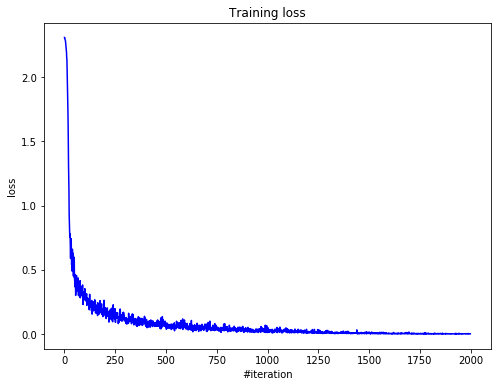

Computation time: 150.975853


In [18]:
numpy_net_loss, numpy_net_time = train(X_train, y_train, net)

In [19]:
import torch, torch.nn as nn
import math
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import datasets, transforms
from torch import nn, optim
import warnings
warnings.filterwarnings("ignore")
transform = transforms.ToTensor()
batch_size=500

In [27]:
def transform(my_x, my_y):
    tensor_x = torch.Tensor(my_x) # transform to torch tensor
    tensor_y = torch.LongTensor(my_y)

    my_dataset = torch.utils.data.TensorDataset(tensor_x,tensor_y) # create your datset
    #my_dataloader = torch.utils.data.DataLoader(my_dataset) # create your dataloader
    return my_dataset

In [28]:
trainloader = torch.utils.data.DataLoader(transform(X_train, y_train), batch_size=500, shuffle=True)
valloader = torch.utils.data.DataLoader(transform(X_val, y_val), batch_size=500, shuffle=True)
testloader = torch.utils.data.DataLoader(transform(X_test, y_test), batch_size=500, shuffle=True)

In [29]:
y_train.shape

(50000,)

In [30]:
model = nn.Sequential()


model.add_module('linear1', nn.Linear(784, 200))
model.add_module('relu1', nn.ReLU())
model.add_module('linear2', nn.Linear(200, 50))
model.add_module('relu2', nn.ReLU())
model.add_module('linear3', nn.Linear(50, 10))
model.add_module('sftmx', nn.LogSoftmax(dim=1))
print(model)

def compute_loss(X_batch, y_batch):
    X_batch = Variable(torch.FloatTensor(X_batch))
    y_batch = Variable(torch.LongTensor(y_batch))
    logits = model(X_batch)
    return F.nll_loss(logits, y_batch).mean()

Sequential(
  (linear1): Linear(in_features=784, out_features=200, bias=True)
  (relu1): ReLU()
  (linear2): Linear(in_features=200, out_features=50, bias=True)
  (relu2): ReLU()
  (linear3): Linear(in_features=50, out_features=10, bias=True)
  (sftmx): LogSoftmax()
)


In [31]:
opt = torch.optim.SGD(model.parameters(), lr=0.1)

train_loss = []
val_accuracy = []

num_epochs = 20

start_time = time()
    
for epoch in range(num_epochs):
    model.train(True)
    i = 0
    for (X_batch, y_batch) in trainloader:
        loss = compute_loss(X_batch, y_batch)
        loss.backward()
        opt.step()
        opt.zero_grad()
        train_loss.append(loss.data.numpy())
    #print()
    i = 0
    model.train(False)
    for X_batch, y_batch in valloader:
        logits = model(Variable(torch.FloatTensor(X_batch)))
        y_pred = logits.max(1)[1].data
        val_accuracy.append(np.mean( (y_batch == y_pred).numpy() ))
fin_time = time()
print('Computation time: %f' % (fin_time - start_time))
    

Computation time: 38.240179


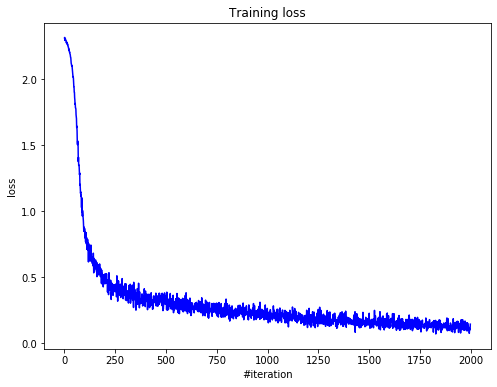

In [32]:
plt.figure(figsize=(8, 6))

plt.title("Training loss")
plt.xlabel("#iteration")
plt.ylabel("loss")
plt.plot(train_loss, 'b')
plt.show()

Time Numpy implementation =  150.97585344314575
Time PyTorch implementation =  38.24017930030823


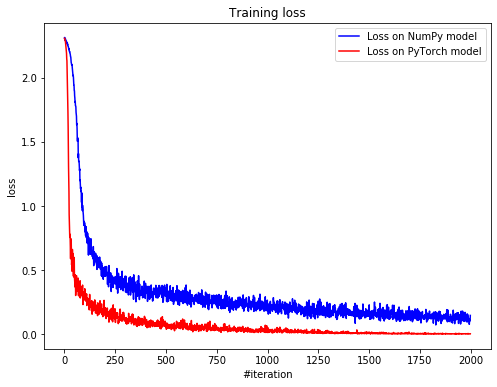

In [34]:
print('Time Numpy implementation = ', numpy_net_time)
print('Time PyTorch implementation = ', fin_time - start_time)
plt.figure(figsize=(8, 6))

plt.title("Training loss")
plt.xlabel("#iteration")
plt.ylabel("loss")
plt.plot(np.array(numpy_net_loss), 'blue', label='Loss on NumPy model')
plt.plot(train_loss, 'red', label='Loss on PyTorch model')

plt.legend()
#plt.show()

plt.savefig('loss_comparation.png')